In [1]:
# Importing Libraries
import torch
from dataloader import FullSizeImageDataset, PatchesDataLoader
from model import build_unet
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2

In [2]:
# Setting device to GPU
device = torch.device("cuda")

In [3]:
transform = transforms.Compose([
    transforms.Resize((9*512,8*512))
])

In [4]:
def generate_patches(loader, size, stride, channels_img, channels_mask):
    for img, mask in loader:
        img.to(device)
        mask = mask.to(device)
        img = img.unfold(1, channels_img, channels_img).unfold(2, size, stride).unfold(3, size, stride)
        img = img.reshape(img.size(0) * img.size(2) * img.size(3), channels_img, size, size)
        mask = mask.unfold(1, 1, 1).unfold(2, size, stride).unfold(3, size, stride)
        mask = mask.reshape(mask.size(0) * mask.size(2) * mask.size(3), channels_mask, size, size)

    return img, mask

In [5]:
def plot_patch(img,mask, pred):
    img = img.squeeze(0).permute(1, 2, 0)
    mask = mask.squeeze(0).permute(1, 2, 0)
    mask = torch.cat([mask, mask, mask], dim=-1)
    pred = pred.squeeze(0).permute(1, 2, 0)
    pred = torch.cat([pred, pred, pred], dim=-1)
    line = (torch.ones((512, 10, 3)) * 128).to(device)
    img_grid = torch.cat([img, line, mask, line, pred], dim=1)
    
    plt.figure(figsize = (20,20))
    plt.imshow(img_grid.detach().cpu().numpy())

In [6]:
train_dataset = FullSizeImageDataset("Colonic_crypt_dataset/train", "Colonic_crypt_dataset/train_mask",
                                     transform=transform)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=1, pin_memory=True)

In [7]:
img, mask = generate_patches(loader=train_loader,
                             size=512,
                             stride=512,
                             channels_img=3,
                             channels_mask=1)

In [8]:
model = build_unet()
model = model.to(device)
model.load_state_dict(torch.load("model_unet.h5"))

<All keys matched successfully>

In [9]:
train_dataset = PatchesDataLoader(img.cpu(), mask.cpu())
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True, num_workers=1)

In [10]:
# Prediction:
model.eval()
for img, mask in train_loader:
    img = img.to(device)
    mask = mask.to(device)
    pred = model(img)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


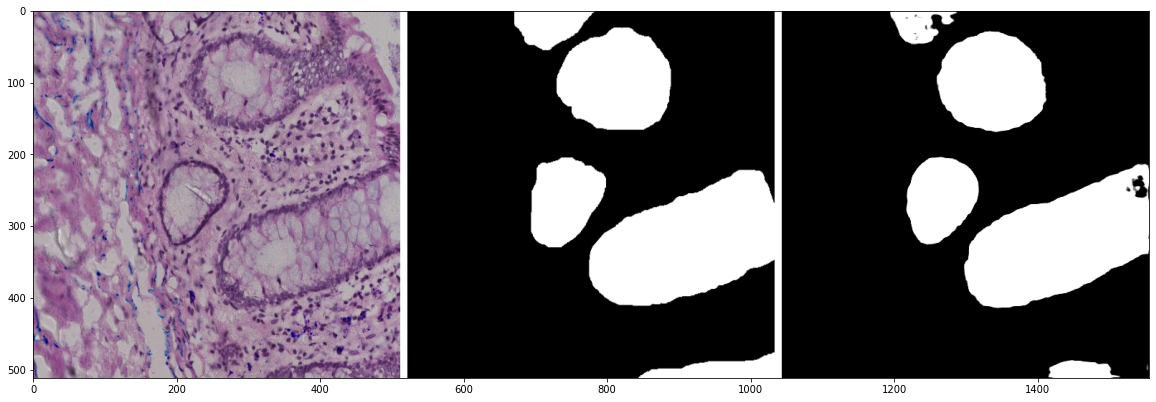

In [11]:
# Plot
plot_patch(img, mask, pred)